En este primer apartado utilizaremos un dataset de Reddit (incluido en este entregador) para intentar clasificar el subreddit al que pertenece un comentario.

- Tarea 1: Preprocesar el dataset. Realiza los pasos necesarios para normalizar el dataset. Las etiquetas que nos interesan principalmente son las de "comment" y "subreddit".  No obstante, puedes utilizar el resto si deseas profundizar para conseguir un mejor resultado.

- Tarea 2: Utiliza y evalúa modelos para clasificar los textos en función de su subreddit. Para ello, deberás utilizar un conjunto de entrenamiento (80% de los datos) y otro de test (20% de los datos). Evalúa con la métrica "precision" el rendimiento de los modelos que pruebes. Deberás prestar atención a describir los métodos que uses para obtener características del texto y para clasificar. Como mínimo debéis utilizar dos procedimientos distintos, uno de ellos siendo de Machine Learning obligatoriamente.

# Clasificación de textos

## Tarea 1: Preprocesar el dataset

In [31]:
import pandas as pd

1. Cargamos el CSV original

In [32]:
file_path = "dataset_reddit.csv"
df = pd.read_csv(file_path, sep=",", encoding="utf-8")


2. Exploramos el dataset

In [33]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      8989 non-null   int64 
 1   label           8989 non-null   int64 
 2   comment         8975 non-null   object
 3   author          8989 non-null   object
 4   subreddit       8989 non-null   object
 5   score           8989 non-null   int64 
 6   ups             8989 non-null   int64 
 7   downs           8989 non-null   int64 
 8   date            8989 non-null   object
 9   created_utc     8989 non-null   object
 10  parent_comment  8989 non-null   object
dtypes: int64(5), object(6)
memory usage: 772.6+ KB
None
   Unnamed: 0  label                                            comment  \
0         235      0  best wall-music experience ever going see roge...   
1         257      0           tend agree you, puppeteers 'persuasive'.   
2         258      0                   

3. Visualizamos y analizamos los contenidos de las etiquetas "comment" y "subreddit"

In [102]:
df = df[["comment", "subreddit"]]

# Eliminar filas con valores NaN
df = df.dropna()
# Verificar
df.isna().sum()


comment      0
subreddit    0
dtype: int64

A simple vista, las siguientes tareas serán:
- Eliminar símbolos relacionados con el salto de línea, tabulaciones y otras similares. (\r)
- Conversión a minúsculas
- Eliminación de puntuaciones
- Eliminación de stopwords
- Eliminación de URLs y etiquetas HTML
- Eliminación de espacios extras/ contracciones

In [103]:
import string
import nltk
from nltk.corpus import stopwords
import contractions
import re
from bs4 import BeautifulSoup
from nltk.stem import SnowballStemmer
import spacy
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\niaib\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\niaib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

4. Limpieza y normalizacion de textos


In [104]:
def clean_text(texto, stemming=True):
    # Conversión a minúsculas
    texto = texto.lower()

    # Eliminar signos de puntuación
    texto = texto.translate(str.maketrans("","",string.punctuation))

    # Eliminar espacios extra
    texto = " ".join(texto.split())

    # Eliminar contracciones
    texto = contractions.fix(texto)

    # Eliminar URLs
    url_pattern = re.compile(r"http[s]?://\S+")
    texto = re.sub(url_pattern,"", texto)

    # Eliminar etiquetas HTML
    texto = BeautifulSoup(texto, "html.parser").get_text()

    # Tokenización
    tokens = nltk.word_tokenize(texto, "english")

    # Eliminar stopwords
    stopwords_en = set(stopwords.words("english"))
    tokens = [w for w in tokens if w not in stopwords_en]

    # Stemmming
    if stemming:
        stemmer = SnowballStemmer("english")
        tokens = [stemmer.stem(w) for w in tokens]
    # Lematización
    else:
        nlp = spacy.load("en_core_webs")
        doc = nlp(" ".join(tokens))
        tokens = [token.lemma_ for token in doc]
    
    # Reconstruir texto limpio
    texto_limpio = " ".join(tokens)
    return texto_limpio


- Ejemplo de transformación tras aplicar la función clean_text():

    - Original: "best wall-music experience ever going see roger..."
    - Limpio: "best wallmus experi ever go see roger water wall"

5. Preprocesar la columna "comment"


In [121]:
df["comment_clean"] = df["comment"].astype(str).apply(clean_text)

# Revisar valores nulos o vacíos
nulos = df["comment_clean"].isnull().sum()
print("\nValores nulos en 'subreddit':", nulos)

vacios = (df["comment_clean"].str.strip() == "").sum()
print("Valores vacíos o solo espacios en 'subreddit_clean':", vacios)

# Eliminar filas donde las columnas tengan cadenas vacías o solo espacios
df = df[df["comment_clean"].str.strip() != ""]
df = df.reset_index(drop=True)



Valores nulos en 'subreddit': 0
Valores vacíos o solo espacios en 'subreddit_clean': 0


6. Preprocesar la columna "subreddit"

Número de clases (subreddits) distintas: 610

Distribución por subreddit:
 subreddit
politics          2412
news               550
worldnews          364
askreddit          351
tumblrinaction     345
                  ... 
googleglass          1
mw3                  1
anarchistnews        1
wiiu                 1
promos               1
Name: count, Length: 610, dtype: int64

Valores nulos en 'subreddit': 0
Valores vacíos o solo espacios en 'subreddit': 0


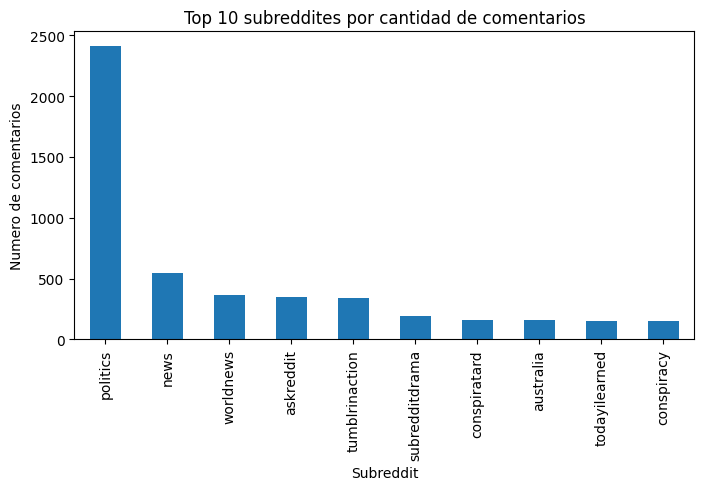

In [122]:
# Valores unicos y cantidad
df['subreddit'] = df['subreddit'].str.lower().str.strip()

categorias = df["subreddit"].value_counts()
print("Número de clases (subreddits) distintas:", len(categorias))
print("\nDistribución por subreddit:\n", categorias)

# Revisar valores nulos o vacíos
nulos = df["subreddit"].isnull().sum()
print("\nValores nulos en 'subreddit':", nulos)

vacios = (df["subreddit"].str.strip() == "").sum()
print("Valores vacíos o solo espacios en 'subreddit':", vacios)

# Visualizar graficamente la distribucion
import matplotlib.pyplot as plt

n = 10
categorias.head(n).plot(kind="bar", figsize=(8,4), title= f'Top {n} subreddites por cantidad de comentarios')
plt.xlabel("Subreddit")
plt.ylabel("Numero de comentarios")
plt.show()


Observamos que el dataset está muy desbalanceado. Esto puede causar un gran problema a la hora de entrenar al modelo. Una posible solución seria limitar la clasificación a los subreddits más frecuentes y agrupar el resto bajo la etiqueta "otros".

- 612 clases diferentes de subreddits
- El subreddit "politics" tiene 2423 comentarios
- Muchos subreddits tienen solo 1 comentario

In [ ]:
top_subs = categorias.index[:10]
df["top_subreddit"] = df["subreddit"].apply(lambda x: x if x in top_subs else "otros")
df["top_subreddit"].value_counts()

In [ ]:
# Generamos una columna con las clases de subreddit si su cantidad es mayor que 1, en otro caso lo agrupamos con la etiqueta "otros"
frec = df["subreddit"].value_counts()
subreddit_mas = frec[frec>1].index

df["subreddit_2"] = df["subreddit"].apply(lambda x: x if x in subreddit_mas else "otros")

Si aplicamos ``y = df["subreddit_2"]`` obtenemos una disminución considerable de la precisión:

- df["top_subreddit"] = 11 clases (10 subreddits + "otros")
- df["subreddit_2"] = ~300-400 clases (todos los subreddits con >1 comentario + "otros")

Una posible solución sería **AUMENTAR EL UMBRAL DE FRECUENCIA**

In [126]:
# Solo subreddits con al menos min_freq comentarios
min_freq = 200
frec = df["subreddit"].value_counts()
subreddit_suficientes = frec[frec>=min_freq].index

df["subreddit_balanced"] = df["subreddit"].apply(lambda x: x if x in subreddit_suficientes else "otros")

print(f"Número de clases: {len(subreddit_suficientes) + 1}")


Número de clases: 6


Vectorizamos los textos para faciliatar el entrenamiento del modelo, ya que los modelos de Machine Learning no entienden palabras, entienden números. Para ello aplicamos un método más robusto que bag-of-words: TF-IDF 

- **``TF-IDF (Term Frequency-Inverse Document Frequency)``**: Es una mejora de BoW. **Pondera las palabras no solo por su frecuencia** en un documento (TF), sino **también por su rareza en todo el corpus (IDF)**. Las palabras que son comunes en un documento pero raras en otros reciben un peso mayor, haciéndolas más significativas.

**``TF-IDF = TF × IDF``**

Donde:
- TF = ``(frecuencia de palabra en documento) / (total palabras en documento)``
- IDF = ``log((total documentos) / (documentos que contienen la palabra))``

Usando solo el top 10 de subreddits

In [109]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split

# # Seleccionamos las variables
# x = df["comment_clean"]
# y = df["top_subreddit"]

# # Dividimos el conjunto de datos en: 80% train y 20% test

# # stratify = y: Garantiza que la proporción de clases (subreddits) se mantenga igual en train y test. Esto es crucial porque el dataset está desbalanceado.
# x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, stratify=y, random_state=42)

# # Vectorización TF-IDF
# tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,4))

# x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
# x_test_tfidf = tfidf_vectorizer.transform(x_test)



Usando todas las clases de subreddit

In [110]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split

# # Seleccionamos las variables
# x = df["comment_clean"]
# y = df["subreddit_2"]

# # Dividimos el conjunto de datos en: 80% train y 20% test
# # stratify = y: Garantiza que la proporción de clases (subreddits) se mantenga igual en train y test. Esto es crucial porque el dataset está desbalanceado.
# x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, stratify=y, random_state=42)

# # Vectorización TF-IDF
# tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))

# x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
# x_test_tfidf = tfidf_vectorizer.transform(x_test)



In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Seleccionamos las variables
x = df["comment_clean"]
y = df["subreddit_balanced"]

# Dividimos el conjunto de datos en: 80% train y 20% test
# stratify = y: Garantiza que la proporción de clases (subreddits) se mantenga igual en train y test. Esto es crucial porque el dataset está desbalanceado.
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, stratify=y, random_state=42)

# Vectorización TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,      # aumentamos el vocabulario
    ngram_range=(1,3),
    min_df = 3,             # ignorar palabras muy raras
    max_df = 0.7,           # Ignorar palabras muy comunes
    sublinear_tf=True,      # Escala logarítmica para TF
    strip_accents="unicode" # Normalización extra
    )

x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)



Comenzamos a entrenar los modelos

1. Modelo de Machine Learning

- **``Random Forest``**

La precisión macro calcula la precisión de cada clase por separado y luego hace un promedio simple de todas ellas, sin importar cuántos datos tenga cada clase.

In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score

modelo = RandomForestClassifier(
    n_estimators=200,
    max_depth=50,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1  # Usar todos los cores
)

# Entrenar al modelo
modelo.fit(x_train_tfidf, y_train)

# Realizar predicciones con los datos de prueba
predicciones = modelo.predict(x_test_tfidf)

print("=" * 60)
print("RANDOM FOREST - UMBRAL 200")
print("=" * 60)
print(classification_report(y_test, predicciones, digits=3))
print(f"\nPrecisión macro: {precision_score(y_test, predicciones, average='macro')*100:.3f}%")

precision = accuracy_score(y_test, predicciones)
print(f"Precisión del modelo: {precision * 100:.2f}%")


RANDOM FOREST - UMBRAL 200
                precision    recall  f1-score   support

     askreddit      0.087     0.100     0.093        70
          news      0.205     0.164     0.182       110
         otros      0.588     0.733     0.653       981
      politics      0.588     0.275     0.375       483
tumblrinaction      0.093     0.101     0.097        69
     worldnews      0.126     0.164     0.143        73

      accuracy                          0.502      1786
     macro avg      0.281     0.256     0.257      1786
  weighted avg      0.507     0.502     0.484      1786


Precisión macro: 28.143%
Precisión del modelo: 50.17%


- **``XGBoost``**

In [130]:
# Instalar primero: pip install xgboost
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# XGBoost requiere labels numéricos
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

modelo = XGBClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss'
)

# Entrenar al modelo
modelo.fit(x_train_tfidf, y_train_encoded)

# Realizar predicciones con los datos de prueba
y_pred_xgb_encoded = modelo.predict(x_test_tfidf)
y_pred_xgb = le.inverse_transform(y_pred_xgb_encoded)

print("=" * 60)
print("XGBOOST - UMBRAL 200")
print("=" * 60)
print(classification_report(y_test, y_pred_xgb, digits=3))
print(f"\nPrecisión macro: {precision_score(y_test, y_pred_xgb, average='macro')*100:.3f}%")

precision = accuracy_score(y_test, y_pred_xgb)
print(f"Precisión del modelo: {precision * 100:.2f}%")

XGBOOST - UMBRAL 200
                precision    recall  f1-score   support

     askreddit      0.000     0.000     0.000        70
          news      0.083     0.009     0.016       110
         otros      0.582     0.933     0.717       981
      politics      0.620     0.246     0.353       483
tumblrinaction      0.000     0.000     0.000        69
     worldnews      0.143     0.014     0.025        73

      accuracy                          0.580      1786
     macro avg      0.238     0.200     0.185      1786
  weighted avg      0.498     0.580     0.491      1786


Precisión macro: 23.801%
Precisión del modelo: 58.01%


### Procedimientos sin usar ML

Para este caso, emplearemos enfoques basados en reglas, heurísticas y diccionarios

#### 1. Clasificación por palabras claves

#### 2. Similitud del coseno con TF-IDF

- **``Similitud del Coseno``**: Mide el **coseno del ángulo entre dos vectores**. Es insensible a la magnitud y se enfoca en la orientación, lo que la hace muy popular para texto. Un **valor de 1 significa idénticos**, **0 significa no relacionados**, y **-1 significa opuestos**.   

In [132]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Preparar datos
subreddits_unicos = df['subreddit_balanced'].unique()
subreddits_unicos = [s for s in subreddits_unicos if s != 'otros']

# Crear "documentos representativos" por subreddit (promedio de todos los comentarios)
subreddit_docs = {}
for sub in subreddits_unicos:
    comments = df[df['subreddit_balanced'] == sub]['comment_clean'].values
    # Concatenar todos los comentarios del subreddit
    subreddit_docs[sub] = ' '.join(comments)

# Vectorizar
vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1,2))
corpus = list(subreddit_docs.values()) + df['comment_clean'].tolist()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Separar vectores de referencia (subreddits) y vectores a clasificar
n_subreddits = len(subreddit_docs)
subreddit_vectors = tfidf_matrix[:n_subreddits]
comment_vectors = tfidf_matrix[n_subreddits:]

def classify_by_similarity(comment_idx, subreddit_vectors, subreddit_names):
    """
    Clasifica el comentario por similitud de coseno con cada subreddit.
    """
    comment_vec = comment_vectors[comment_idx]
    similarities = cosine_similarity(comment_vec, subreddit_vectors)[0]
    
    # Si la similitud máxima es muy baja, clasificar como 'otros'
    max_sim = max(similarities)
    if max_sim < 0.1:  # Umbral de similitud
        return 'otros'
    
    best_match_idx = np.argmax(similarities)
    return subreddit_names[best_match_idx]

# Aplicar clasificación
subreddit_names = list(subreddit_docs.keys())
df['pred_similarity'] = [
    classify_by_similarity(i, subreddit_vectors, subreddit_names) 
    for i in range(len(df))
]

print("\n" + "=" * 60)
print("MÉTODO 2: SIMILITUD DE COSENO CON TF-IDF")
print("=" * 60)
print(classification_report(df['subreddit_balanced'], 
                           df['pred_similarity'], 
                           digits=3))
print(f"Precisión del modelo: {accuracy_score(df['subreddit_balanced'], df['pred_similarity'])*100:.3f}%")
print(f"Precision (macro): {precision_score(df['subreddit_balanced'], df['pred_similarity'], average='macro', zero_division=0)*100:.3f}%")


MÉTODO 2: SIMILITUD DE COSENO CON TF-IDF
                precision    recall  f1-score   support

     askreddit      0.203     0.319     0.248       351
          news      0.264     0.355     0.303       550
         otros      0.592     0.704     0.643      4905
      politics      0.593     0.229     0.331      2412
tumblrinaction      0.278     0.359     0.314       345
     worldnews      0.266     0.305     0.284       364

      accuracy                          0.510      8927
     macro avg      0.366     0.379     0.354      8927
  weighted avg      0.531     0.510     0.495      8927

Precisión del modelo: 50.969%
Precision (macro): 36.584%


#### 3. Clasificación mediante n-gramas

In [133]:
# CountVectorizer: convierte texto en una matriz de conteo de palabras
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict

def extraer_top_ngrams(texts, n=2, top_k=20):
    """
    Extrae los top-k n-gramas más frecuentes de un conjunto de textos.
    """
    vectorizador = CountVectorizer(ngram_range=(n, n), max_features=top_k)
    try:
        X = vectorizador.fit_transform(texts)
        ngrams = vectorizador.get_feature_names_out()
        frecuencias = X.sum(axis=0).A1
        return list(zip(ngrams, frecuencias))
    except:
        return []

# Extraer n-gramas característicos por subreddit
subreddits_unicos = df['subreddit_balanced'].unique()
subreddits_unicos = [s for s in subreddits_unicos if s != "otros"]

subreddit_signatures = {}
for sub in subreddits_unicos:
    comments = df[df['subreddit_balanced'] == sub]['comment_clean'].values
    if len(comments) > 10:  # Solo si hay suficientes ejemplos
        bigrams = extraer_top_ngrams(comments, n=2, top_k=30)
        trigrams = extraer_top_ngrams(comments, n=3, top_k=20)
        # Combinar bi-gramas y tri-gramas
        signature = [gram for gram, freq in bigrams + trigrams]
        subreddit_signatures[sub] = signature

# Mostrar ejemplos
print("=" * 60)
print("FIRMAS CARACTERÍSTICAS POR SUBREDDIT (N-GRAMAS)")
print("=" * 60)
for sub, signature in list(subreddit_signatures.items())[:3]:
    print(f"\n{sub}:")
    print(signature[:10])

def classify_by_ngrams(text, signatures):
    """
    Clasifica el texto según qué n-gramas característicos contiene.
    """
    scores = defaultdict(int)
    
    for subreddit, ngrams in signatures.items():
        for ngram in ngrams:
            if ngram in text:
                scores[subreddit] += 1
    
    if not scores or max(scores.values()) == 0:
        return 'otros'
    
    return max(scores, key=scores.get)

# Aplicar clasificación
df['pred_ngrams'] = df['comment_clean'].apply(
    lambda x: classify_by_ngrams(x, subreddit_signatures)
)

print("\n" + "=" * 60)
print("MÉTODO 3: CLASIFICACIÓN POR N-GRAMAS CARACTERÍSTICOS")
print("=" * 60)
print(classification_report(df['subreddit_balanced'], 
                           df['pred_ngrams'], 
                           digits=3))
print(f"\nPrecisión del modelo: {accuracy_score(df['subreddit_balanced'], df['pred_ngrams'])*100:.3f}%")
print(f"Precision (macro): {precision_score(df['subreddit_balanced'], df['pred_ngrams'], average='macro', zero_division=0)*100:.3f}%")

FIRMAS CARACTERÍSTICAS POR SUBREDDIT (N-GRAMAS)

tumblrinaction:
['act like', 'behind back', 'black peopl', 'everi day', 'gay agenda', 'id rather', 'let us', 'live matter', 'part silli', 'rape cultur']

politics:
['african american', 'bla bla', 'donald trump', 'everyon know', 'fox news', 'free market', 'free speech', 'go wrong', 'good enough', 'good thing']

news:
['absolut everyon', 'absolut noth', 'bad luck', 'brave hero', 'caught first', 'drug war', 'extrem bad', 'first time', 'go home', 'good thing']

MÉTODO 3: CLASIFICACIÓN POR N-GRAMAS CARACTERÍSTICOS
                precision    recall  f1-score   support

     askreddit      0.489     0.125     0.200       351
          news      0.438     0.096     0.158       550
         otros      0.568     0.949     0.710      4905
      politics      0.609     0.073     0.130      2412
tumblrinaction      0.388     0.165     0.232       345
     worldnews      0.662     0.140     0.231       364

      accuracy                          0.

## Mejoras

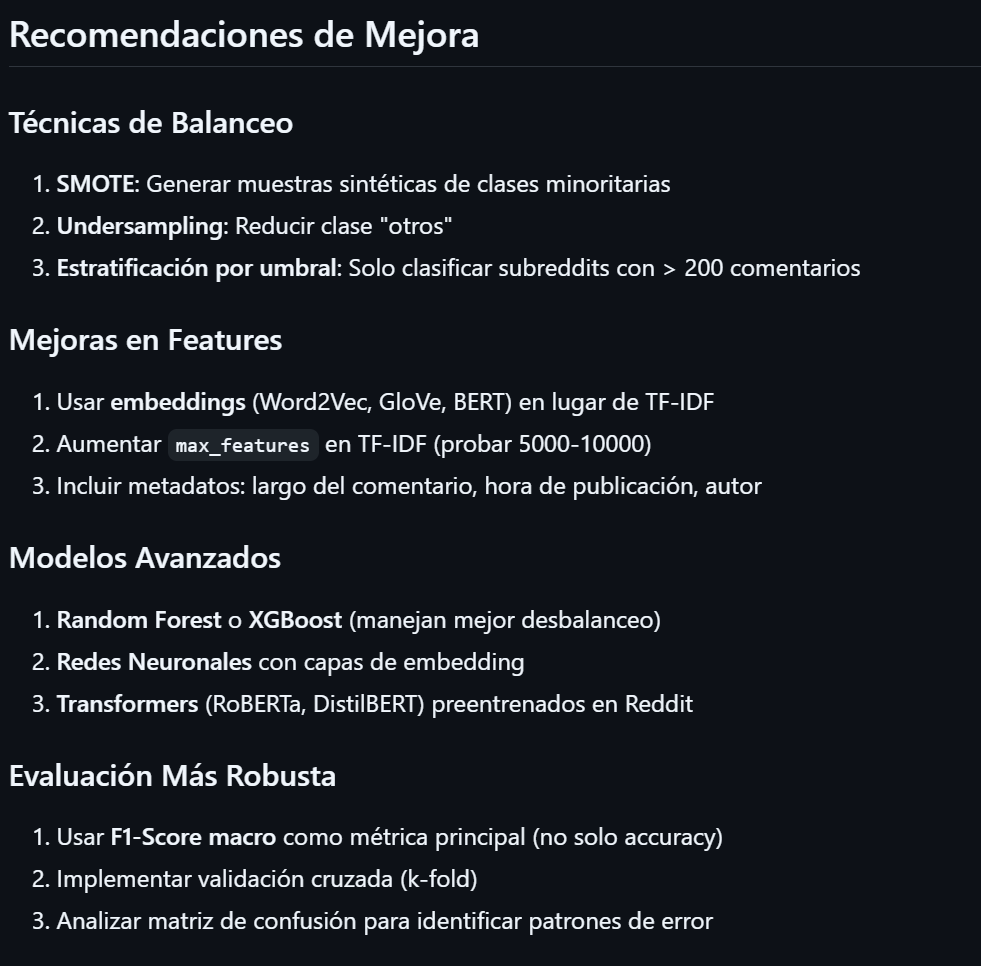

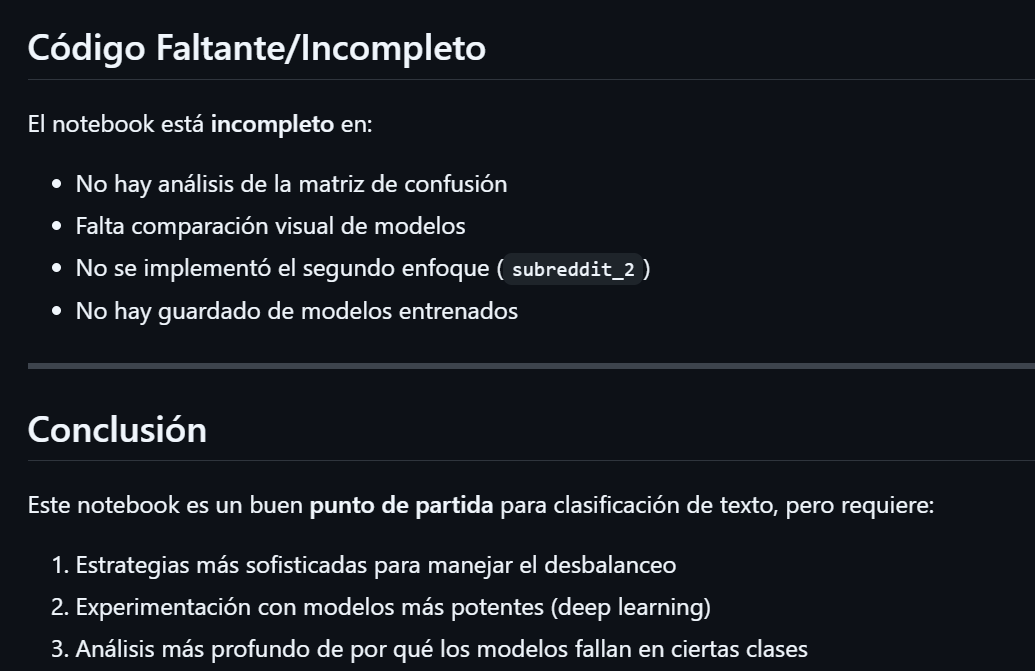

### Tecnicas de Balanceo